In [1]:
import sys

# Add the parent directory to the system path
sys.path.append("../04_survival_models/src")

In [2]:
import datetime
import json
import math
import os
import pickle
import pprint
import time
import warnings

import joblib
import kaplanmeier as km
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from azureml.core import Dataset, Workspace
from lifelines.statistics import logrank_test
from sksurv.nonparametric import kaplan_meier_estimator
from tabulate import tabulate
from uc2_functions import *
from tqdm import tqdm

In [3]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [4]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Goal

The goal is to explore the data and plot survival curves.

# Parameters

In [5]:
# Legend
PATH_LEGEND = "Legenda_Variabili_Uri_Larcher.xlsx"
# Directories
DIR_SC = os.path.join(os.path.dirname(os.getcwd()), "sc")  # Legend

# Data ingestion

## One-hot encoding version

In [6]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required

subscription_id = "753a0b42-95dc-4871-b53e-160ceb0e6bc1"
resource_group = "rg-s-race-aml-dev-we"
workspace_name = "amlsraceamldevwe01"

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name="UC2_raw_survival_csm_ohe_5yrs")
df_ohe = dataset.to_pandas_dataframe()
print(df_ohe.shape)
df_ohe.head()

{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
(2536, 211)


,P_1_id,ANM_1_previousAbdominalOperations,ANM_1_moduliOK,ANM_1_performanceStatus,ANM_1_asa,ANM_1_patientBMI,ANM_1_hypertension,ANM_1_TerapiaDiabeteIpoglicemizzanti,ANM_1_charlsonIndexComorbiditiesMalattiaPolmonare,ANM_1_charlsonIndexComorbiditiesUlceraPeptica,...,DEG_1_examEmCreatininemiaRange_14-18,DEG_1_examEmCalcioRange_14-18,"DEG_1_examEmCalcioRange_2,10-2,60",DEG_1_examEmCalcioRange_2_1-2_6,DEG_1_examEmCalcioRange_2_10-2_60,DEG_1_examEmCalcioRange_2_25-2_75,death,csm,ocm,ttdeath
0,1.0,False,False,0.0,1.0,24.82,False,<NA>,True,False,...,False,False,False,False,True,False,False,False,True,60.0
1,4.0,False,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,<NA>,<NA>,60.0
2,5.0,True,False,1.0,2.0,NaN,True,False,False,False,...,False,False,False,False,True,False,False,False,False,60.0
3,6.0,False,False,1.0,2.0,29.76,False,<NA>,False,False,...,False,False,False,False,True,False,False,False,False,60.0
4,7.0,True,False,1.0,2.0,26.57,False,False,False,False,...,False,False,False,False,False,False,False,False,False,60.0


### Use schema

Recreate the schema from tags:

In [7]:
tags = dataset.tags

dtypes = json.loads(tags["dtypes_json"])
is_ordinal = json.loads(tags["is_ordinal_json"])

for col in dtypes.keys():
    if dtypes[col] == "category":
        categories = (
            sorted(df_ohe[col].dropna().unique())
            if is_ordinal[col]
            else df_ohe[col].dropna().unique()
        )
        df_ohe[col] = pd.Categorical(
            df_ohe[col], categories=categories, ordered=is_ordinal[col]
        )
    else:
        df_ohe[col] = df_ohe[col].astype(dtypes[col])

In [8]:
count_columns_by_dtype(df_ohe)

float64: 31
boolean: 171
ordinal category: 9
non ordinal category: 0


## `.xlsx` Legend

In [9]:
df_legend = pd.read_excel(
    os.path.join(DIR_SC, PATH_LEGEND), sheet_name="Variabili Etichette DBURI"
)
df_legend.head()

,Variabile,Etichetta,Dati
0,P_1_id,Paziente 1 id,NaN
1,P_1_idCentral,Paziente 1 Id Anagrafica Centrale,NaN
2,P_1_lastname,Paziente 1 Cognome,NaN
3,P_1_firstname,Paziente 1 Nome,NaN
4,P_1_dateofbirth,Paziente 1 Data di nascita,NaN


### Create dictionary

In [10]:
dict_legend = pd.Series(
    df_legend["Etichetta"].values, index=df_legend["Variabile"]
).to_dict()

# Drop na on target columns

In [11]:
not_features = ["P_1_id", "death", "csm", "ocm", "ttdeath"]

In [12]:
print(df_ohe.shape[0])
df_ohe = df_ohe.dropna(subset=["ttdeath", "death"])
print(df_ohe.shape[0])

2536
2536


# Copy df

In [13]:
df_eda = df_ohe.copy()

# Boxplot

## Tumor size

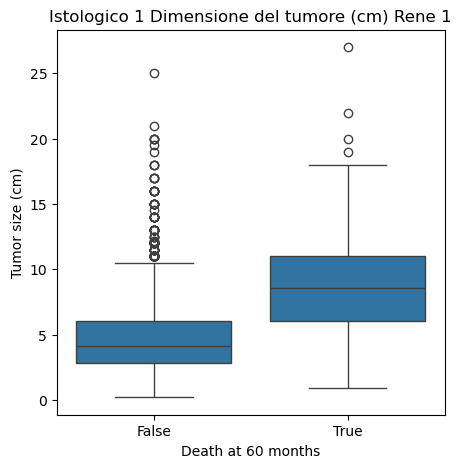

In [14]:
fig = plt.figure(figsize=(5, 5))
sns.boxplot(x="death", y="IST_1_kidney1TumorDimension", data=df_eda)
plt.xlabel("Death at 60 months")
plt.ylabel("Tumor size (cm)")
plt.title(dict_legend["IST_1_kidney1TumorDimension"])
plt.show()

# Piastrine

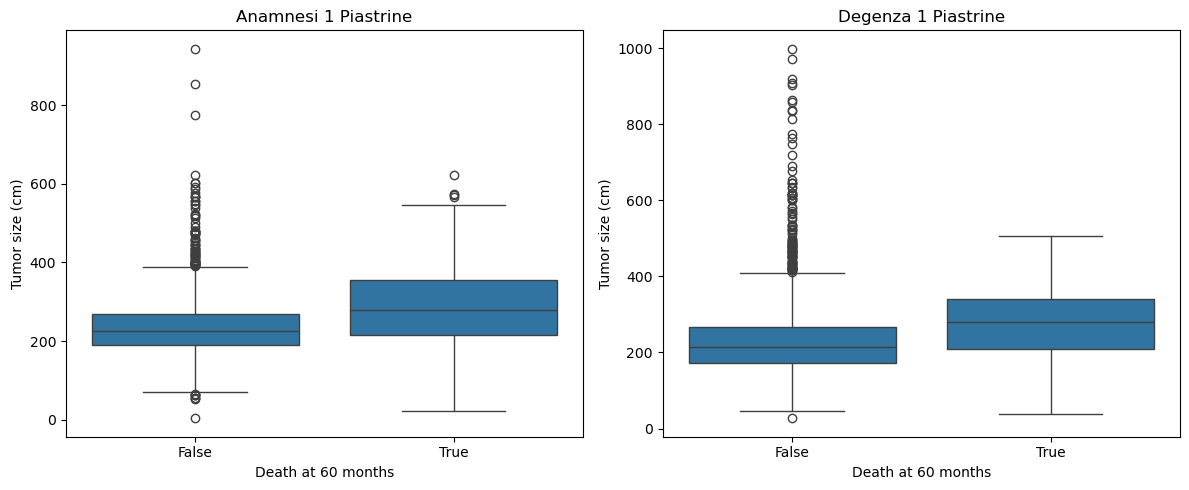

In [15]:
y_vars = ["ANM_1_examEmPiastrine", "DEG_1_examEmPiastrine"]

# Define the number of subplots
n_cols = 2
n_rows = 1
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))  # Adjust figsize as needed
# If only one row and multiple columns, axes will be a 1D array
for ax, y_var in zip(axes, y_vars):
    sns.boxplot(x="death", y=y_var, data=df_eda, ax=ax)
    ax.set_xlabel("Death at 60 months")
    ax.set_ylabel("Tumor size (cm)")
    ax.set_title(dict_legend.get(y_var, y_var))  # Use the legend if available, else the y_var name
plt.tight_layout()
plt.show()

# Emoglobina

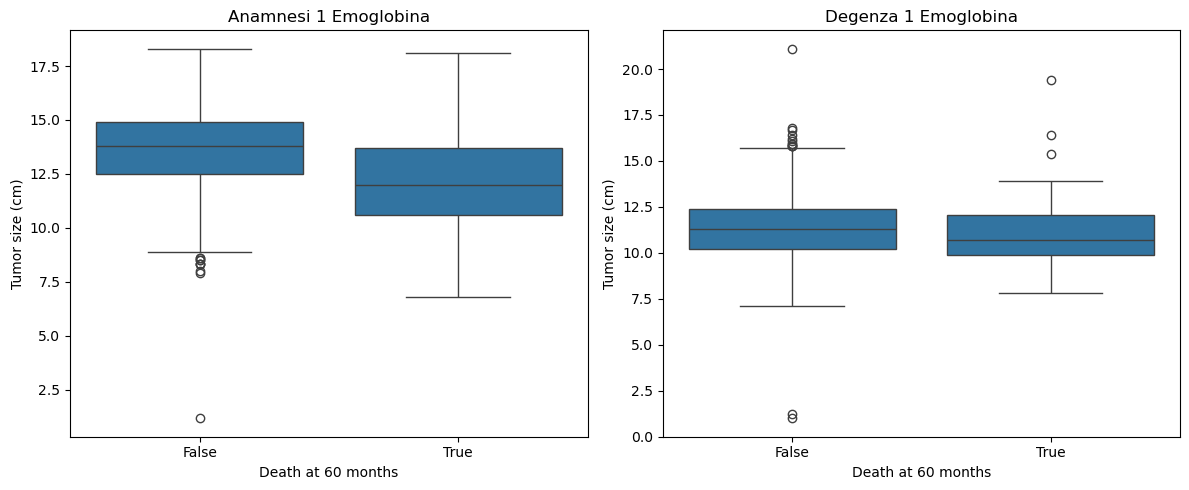

In [16]:
y_vars = ["ANM_1_examEmEmoglobina", "DEG_1_examEmEmoglobina"]

# Define the number of subplots
n_cols = 2
n_rows = 1
# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5))  # Adjust figsize as needed
# If only one row and multiple columns, axes will be a 1D array
for ax, y_var in zip(axes, y_vars):
    sns.boxplot(x="death", y=y_var, data=df_eda, ax=ax)
    ax.set_xlabel("Death at 60 months")
    ax.set_ylabel("Tumor size (cm)")
    ax.set_title(dict_legend.get(y_var, y_var))  # Use the legend if available, else the y_var name
plt.tight_layout()
plt.show()

# Kaplan–Meier

## Population

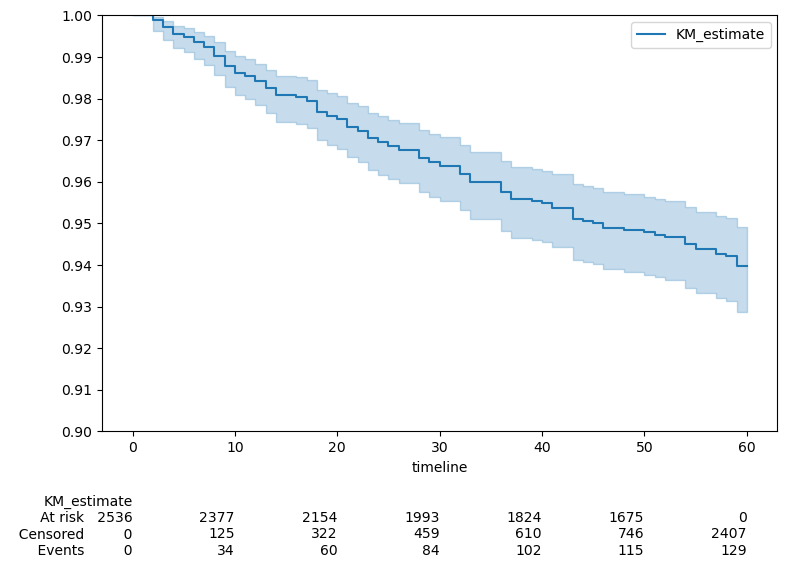

In [17]:
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

kmf_0 = KaplanMeierFitter()
ax = kmf_0.fit(durations=df_eda['ttdeath'],
                     event_observed=df_eda['death']).plot_survival_function(ax=ax, )
ax.set_ylim(0.9, 1)
ax.set_yticks(np.arange(0.9, 1.01, 0.01))
add_at_risk_counts(kmf_0, ax=ax)
plt.tight_layout()

## Age

Logrank Test between <=60 and >60: p-value = 0.0102


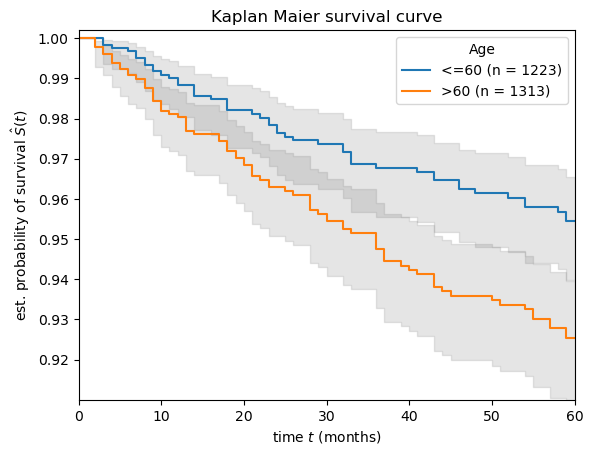

In [18]:
# Age over 60
df_eda["age_over_60"] = np.where(df_eda["ANM_1_age"] > 60, ">60", "<=60")
plot_kaplanmeier(
    df=df_eda,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="age_over_60",
    legend_title="Age",
)

## Gender

Logrank Test between Female and Male: p-value = 0.0777


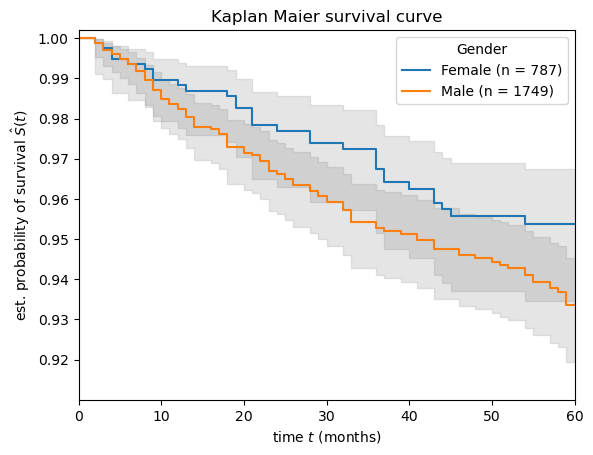

In [19]:
# Gender from bool to string
df_eda["gender"] = np.where(df_eda["P_1_sex_M"] == True, "Male", "Female")
plot_kaplanmeier(
    df=df_eda,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="gender",
    legend_title="Gender",
)

## Thrombocytosis

In [1]:
# Thrombocytosis at T0
#Anemia: Defined by specific hemoglobin thresholds (<13 g/dL for men and <12 g/dL for women).
df_eda["thrombocytosis"] = np.where(
    ((df_eda["P_1_sex_M"]) & (df_eda["ANM_1_examEmPiastrine"] < 13)) |
    ((~df_eda["P_1_sex_M"]) & (df_eda["ANM_1_examEmPiastrine"] < 12)),
    "Thrombocytosis",
    "No thrombocytosis"
)
plot_kaplanmeier(
    df=df_eda.dropna(subset="anemia"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="anemia",
    legend_title="Anemia",
)

NameError: name 'np' is not defined

## Anemia

Logrank Test between Anemia and No anemia: p-value = 0.0000


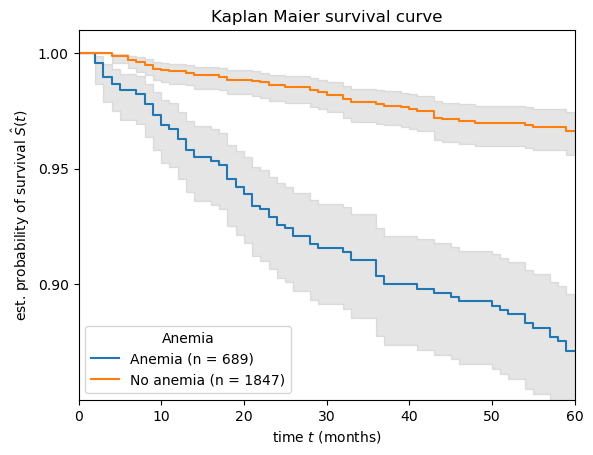

In [20]:
# Anemia at T0
#Anemia: Defined by specific hemoglobin thresholds (<13 g/dL for men and <12 g/dL for women).
df_eda["anemia"] = np.where(
    ((df_eda["P_1_sex_M"]) & (df_eda["ANM_1_examEmEmoglobina"] < 13)) |
    ((~df_eda["P_1_sex_M"]) & (df_eda["ANM_1_examEmEmoglobina"] < 12)),
    "Anemia",
    "No anemia"
)
plot_kaplanmeier(
    df=df_eda.dropna(subset="anemia"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="anemia",
    legend_title="Anemia",
)

## Surgery type

Logrank Test between Nefrectomia and Tumorectomia: p-value = 0.0000


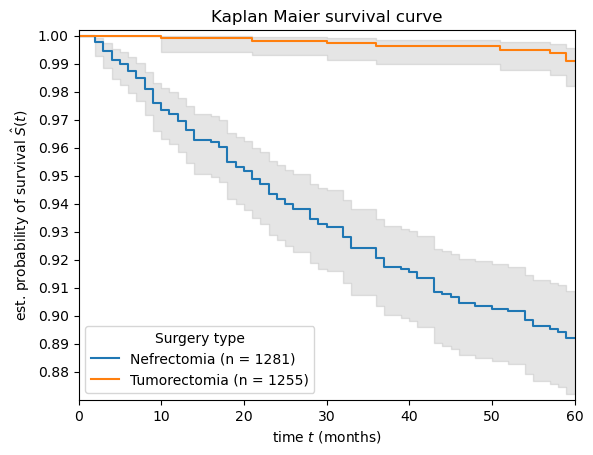

In [21]:
# Surgery type from bool to string
df_eda["surgery_type"] = np.where(
    df_eda["INT_1_kidney1OperationType_Tumorectomia"] == True,
    "Tumorectomia",
    "Nefrectomia",
)
plot_kaplanmeier(
    df=df_eda,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="surgery_type",
    legend_title="Surgery type",
)

## Blood

Logrank Test between <=1.5 and >1.5: p-value = 0.0000


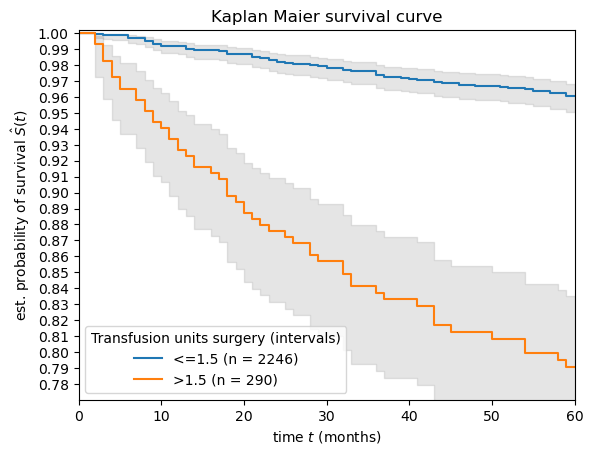

In [22]:
# Blood
df_eda["transfusion_units_surgery_intervals"] = np.where(
    df_eda["INT_1_transfusionsTot"] > 1.5, ">1.5", "<=1.5"
)
plot_kaplanmeier(
    df=df_eda,
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.01,
    col_groupby="transfusion_units_surgery_intervals",
    legend_title="Transfusion units surgery (intervals)",
)

## pT

Logrank Test between 1.0 and 2.0: p-value = 0.0000
Logrank Test between 1.0 and 3.0: p-value = 0.0000
Logrank Test between 1.0 and 4.0: p-value = 0.0000
Logrank Test between 2.0 and 3.0: p-value = 0.0067
Logrank Test between 2.0 and 4.0: p-value = 0.0000
Logrank Test between 3.0 and 4.0: p-value = 0.0000


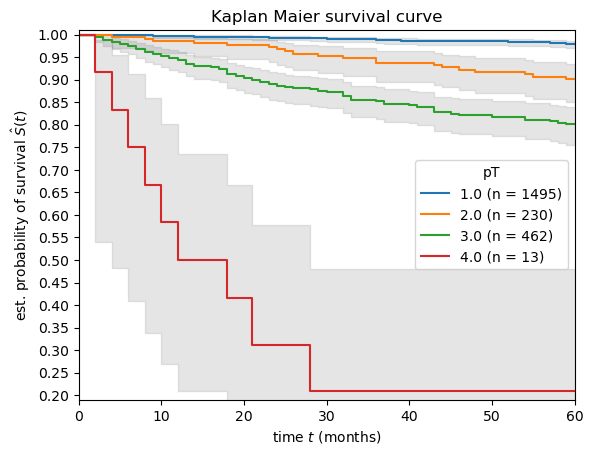

In [23]:
plot_kaplanmeier(
    df=df_eda.dropna(subset="IST_1_kidney1PathologicalStage2009_4lev"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="IST_1_kidney1PathologicalStage2009_4lev",
    legend_title="pT",
)

## pN

Logrank Test between False and True: p-value = 0.0000


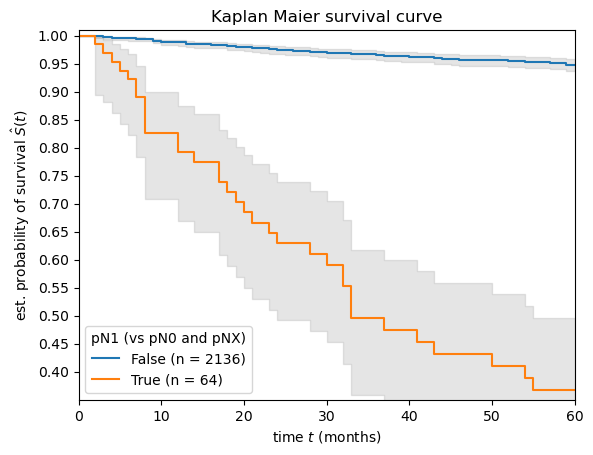

In [24]:
# Between pN1 and others
plot_kaplanmeier(
    df=df_eda.dropna(subset="IST_1_kidney1PathologicalStage2009_4lev"),
    event_col="death",
    time_col="ttdeath",
    tau_months=60,
    ydef=0.05,
    col_groupby="IST_1_kidney1PN2009_1_0",
    legend_title="pN1 (vs pN0 and pNX)",
)